# 08.1 Instrumental Variables Intuition

**Chapter**: 8 - Instrumental Variables  
**Section**: 1 - Going Around Omitted Variable Bias  
**Facure Source**: 08-Instrumental-Variables.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The OVB Problem](#11-the-ovb-problem)
   - 1.2 [The IV Solution](#12-the-iv-solution)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Instrument Validity Conditions](#21-instrument-validity-conditions)
   - 2.2 [The IV Estimator](#22-the-iv-estimator)
   - 2.3 [The Wald Estimator](#23-the-wald-estimator)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [DAG Visualization](#31-dag-visualization)
   - 3.2 [Simulation: IV Recovers Causal Effect](#32-simulation-iv-recovers-causal-effect)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    create_tufte_figure,
    TUFTE_PALETTE,
)

import graphviz as gr

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: IV is a cornerstone of causal inference in observational data. Interviewers test whether you understand *when* IV is valid and *why* it identifies causal effects.

### 1.1 The OVB Problem

One way to control for OVB is to add the omitted variable into our model. However, that is not always possible—mostly because we simply don't have data on the omitted variables.

Consider the classic education-wage example:

$$\log(\text{wage})_i = \beta_0 + \kappa \cdot \text{educ}_i + \boldsymbol{\beta}\text{Ability}_i + u_i$$

To figure out the causal effect $\kappa$ of education on log-wage, we need to control for ability factors. If we don't, we have bias—ability is a **confounder**, causing both education and earnings.

★ Insight ─────────────────────────────────────
- **OVB Formula**: $\text{Bias} = \rho_{T,U} \cdot \gamma$ where $U$ is the omitted confounder
- Ability likely causes *both* more education *and* higher wages
- Without controlling for ability, $\hat{\kappa}$ is biased upward
─────────────────────────────────────────────────

### 1.2 The IV Solution

**Enter Instrumental Variables.** The idea is to find another variable $Z$ that:

1. **Causes the treatment** (affects education)
2. **Only affects the outcome through the treatment** (no direct effect on wages)

Another way of saying this: $Z$ is uncorrelated with $Y_0$ (potential outcome without treatment), but correlated with $T$. This is the **exclusion restriction**.

As Facure puts it: *"If we have such a variable, we can recover the causal effect $\kappa$ with what we will see as the IV formula."*

---

## 2. Formal Treatment

### 2.1 Instrument Validity Conditions

An instrument $Z$ must satisfy **three conditions** for valid identification[^1][^2]:

| Condition | Formal Statement | Intuition |
|-----------|------------------|----------|
| **Relevance** | $\text{Cov}(Z, T) \neq 0$ | Instrument affects treatment |
| **Exogeneity** | $\text{Cov}(Z, u) = 0$ | Instrument uncorrelated with error |
| **Exclusion Restriction** | $Z \to Y$ only via $T$ | No direct effect on outcome |

**Key insight**: Only **relevance** is testable from data. Exogeneity and exclusion are *identification assumptions*—they must be argued, not verified[^3].

### 2.2 The IV Estimator

**Setup**: We want to estimate the causal model:

$$Y_i = \beta_0 + \kappa T_i + \boldsymbol{\beta}W_i + u_i$$

where $W_i$ contains unobserved confounders. Without $W$, we can only estimate:

$$Y_i = \beta_0 + \kappa T_i + v_i \quad \text{where } v_i = \boldsymbol{\beta}W_i + u_i$$

Since $W$ confounds $T$, we have $\text{Cov}(T, v) \neq 0$, biasing OLS.

**Derivation of IV Estimator**:

By the exclusion restriction, $\text{Cov}(Z, v) = 0$. Taking covariance with $Z$:

$$\text{Cov}(Z, Y) = \text{Cov}(Z, \beta_0 + \kappa T + v) = \kappa \cdot \text{Cov}(Z, T) + \underbrace{\text{Cov}(Z, v)}_{=0}$$

Solving for $\kappa$:

$$\boxed{\kappa_{IV} = \frac{\text{Cov}(Y, Z)}{\text{Cov}(T, Z)}}$$

Dividing numerator and denominator by $\text{Var}(Z)$:

$$\kappa_{IV} = \frac{\text{Cov}(Y, Z)/\text{Var}(Z)}{\text{Cov}(T, Z)/\text{Var}(Z)} = \frac{\text{Reduced Form}}{\text{First Stage}}$$

where:
- **Reduced Form**: Regression of $Y$ on $Z$ (effect of instrument on outcome)
- **First Stage**: Regression of $T$ on $Z$ (effect of instrument on treatment)

### 2.3 The Wald Estimator

When $Z$ is binary, the IV estimator simplifies to the **Wald estimator**:

$$\kappa_{Wald} = \frac{E[Y|Z=1] - E[Y|Z=0]}{E[T|Z=1] - E[T|Z=0]}$$

**Interpretation**: Scale the effect of $Z$ on $Y$ by the effect of $Z$ on $T$ to convert from $Z$-units to $T$-units.

★ Insight ─────────────────────────────────────
- Wald estimator is a **ratio of differences in means**
- Numerator: intention-to-treat effect
- Denominator: compliance rate (how much $Z$ shifts $T$)
- If denominator → 0, IV variance → ∞ (weak instruments)
─────────────────────────────────────────────────

---

## 3. Numeric Demonstration

### 3.1 DAG Visualization

Let's visualize the confounded relationship and how an instrument helps.

(a) Confounded: OLS biased because ability affects both


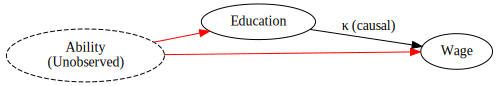

In [2]:
# DAG 1: Confounded relationship (no instrument)
g1 = gr.Digraph(name='Confounded')
g1.attr(rankdir='LR')
g1.node('ability', 'Ability\n(Unobserved)', style='dashed')
g1.node('educ', 'Education')
g1.node('wage', 'Wage')
g1.edge('ability', 'educ', color='red')
g1.edge('ability', 'wage', color='red')
g1.edge('educ', 'wage', label='κ (causal)')
print("(a) Confounded: OLS biased because ability affects both")
g1

(b) With IV: Quarter of birth only affects wage THROUGH education


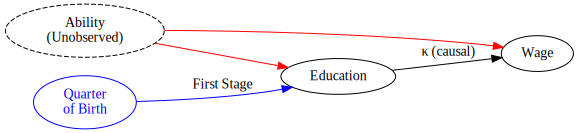

In [3]:
# DAG 2: With instrument (quarter of birth)
g2 = gr.Digraph(name='IV')
g2.attr(rankdir='LR')
g2.node('ability', 'Ability\n(Unobserved)', style='dashed')
g2.node('educ', 'Education')
g2.node('wage', 'Wage')
g2.node('qob', 'Quarter\nof Birth', color='blue', fontcolor='blue')
g2.edge('ability', 'educ', color='red')
g2.edge('ability', 'wage', color='red')
g2.edge('educ', 'wage', label='κ (causal)')
g2.edge('qob', 'educ', color='blue', label='First Stage')
# Note: NO edge from qob to wage (exclusion restriction)
print("(b) With IV: Quarter of birth only affects wage THROUGH education")
g2

### 3.2 Simulation: IV Recovers Causal Effect

Let's simulate a scenario where OLS is biased but IV recovers the true effect.

In [4]:
# Simulate confounded data with instrument
np.random.seed(42)
n = 5000

# True causal effect
TRUE_KAPPA = 2.0

# Unobserved confounder
U = np.random.normal(0, 1, n)

# Instrument: affects T but not Y directly
Z = np.random.binomial(1, 0.5, n)

# Treatment: affected by instrument AND confounder
T = 0.5 + 0.8 * Z + 0.6 * U + np.random.normal(0, 0.5, n)

# Outcome: affected by treatment AND confounder (NOT instrument directly)
Y = 1.0 + TRUE_KAPPA * T + 1.5 * U + np.random.normal(0, 1, n)

sim_data = pd.DataFrame({'Y': Y, 'T': T, 'Z': Z, 'U': U})
print(f"True causal effect: κ = {TRUE_KAPPA}")
print(f"Sample size: n = {n}")

True causal effect: κ = 2.0
Sample size: n = 5000


In [5]:
# Compare OLS vs IV
import statsmodels.formula.api as smf

# OLS (biased - doesn't control for U)
ols_result = smf.ols('Y ~ T', data=sim_data).fit()
ols_coef = ols_result.params['T']
ols_bias = ols_coef - TRUE_KAPPA

# IV by hand: Reduced Form / First Stage
reduced_form = smf.ols('Y ~ Z', data=sim_data).fit()
first_stage = smf.ols('T ~ Z', data=sim_data).fit()
iv_coef = reduced_form.params['Z'] / first_stage.params['Z']
iv_bias = iv_coef - TRUE_KAPPA

# Oracle (if we could observe U)
oracle_result = smf.ols('Y ~ T + U', data=sim_data).fit()
oracle_coef = oracle_result.params['T']
oracle_bias = oracle_coef - TRUE_KAPPA

print("COMPARISON OF ESTIMATORS")
print("=" * 50)
print(f"{'Method':<20} {'Estimate':>12} {'Bias':>12}")
print("-" * 50)
print(f"{'True Effect':<20} {TRUE_KAPPA:>12.4f} {0:>12.4f}")
print(f"{'OLS (biased)':<20} {ols_coef:>12.4f} {ols_bias:>12.4f}")
print(f"{'IV (RF/FS)':<20} {iv_coef:>12.4f} {iv_bias:>12.4f}")
print(f"{'Oracle (with U)':<20} {oracle_coef:>12.4f} {oracle_bias:>12.4f}")

COMPARISON OF ESTIMATORS
Method                   Estimate         Bias
--------------------------------------------------
True Effect                2.0000       0.0000
OLS (biased)               3.2020       1.2020
IV (RF/FS)                 1.9552      -0.0448
Oracle (with U)            2.0157       0.0157


In [6]:
# Verify IV formula: κ = Cov(Y,Z) / Cov(T,Z)
cov_yz = np.cov(sim_data['Y'], sim_data['Z'])[0, 1]
cov_tz = np.cov(sim_data['T'], sim_data['Z'])[0, 1]
iv_cov_formula = cov_yz / cov_tz

print("\nVERIFYING IV FORMULA")
print("=" * 50)
print(f"Cov(Y, Z) = {cov_yz:.6f}")
print(f"Cov(T, Z) = {cov_tz:.6f}")
print(f"κ_IV = Cov(Y,Z)/Cov(T,Z) = {iv_cov_formula:.6f}")
print(f"κ_IV (from regressions) = {iv_coef:.6f}")
print(f"Match: {np.isclose(iv_cov_formula, iv_coef)}")

assert np.isclose(iv_cov_formula, iv_coef, rtol=1e-10)


VERIFYING IV FORMULA
Cov(Y, Z) = 0.376052
Cov(T, Z) = 0.192338
κ_IV = Cov(Y,Z)/Cov(T,Z) = 1.955163
κ_IV (from regressions) = 1.955163
Match: True


In [7]:
# Verify Wald estimator (since Z is binary)
mean_y_z1 = sim_data.query('Z == 1')['Y'].mean()
mean_y_z0 = sim_data.query('Z == 0')['Y'].mean()
mean_t_z1 = sim_data.query('Z == 1')['T'].mean()
mean_t_z0 = sim_data.query('Z == 0')['T'].mean()

wald_estimate = (mean_y_z1 - mean_y_z0) / (mean_t_z1 - mean_t_z0)

print("\nWALD ESTIMATOR (Binary Instrument)")
print("=" * 50)
print(f"E[Y|Z=1] - E[Y|Z=0] = {mean_y_z1 - mean_y_z0:.6f} (Reduced Form)")
print(f"E[T|Z=1] - E[T|Z=0] = {mean_t_z1 - mean_t_z0:.6f} (First Stage)")
print(f"Wald estimate = {wald_estimate:.6f}")
print(f"IV estimate = {iv_coef:.6f}")
print(f"Match: {np.isclose(wald_estimate, iv_coef)}")

assert np.isclose(wald_estimate, iv_coef, rtol=1e-10)


WALD ESTIMATOR (Binary Instrument)
E[Y|Z=1] - E[Y|Z=0] = 1.504418 (Reduced Form)
E[T|Z=1] - E[T|Z=0] = 0.769459 (First Stage)
Wald estimate = 1.955163
IV estimate = 1.955163
Match: True


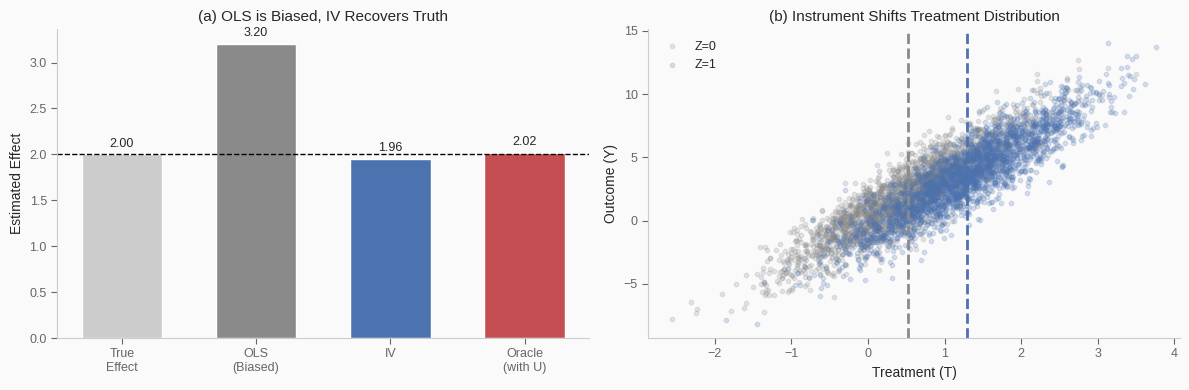

In [8]:
# Visualize results
fig, axes = create_tufte_figure(1, 2, figsize=(12, 4))

# Panel 1: OLS vs IV comparison
ax = axes[0]
methods = ['True\nEffect', 'OLS\n(Biased)', 'IV', 'Oracle\n(with U)']
estimates = [TRUE_KAPPA, ols_coef, iv_coef, oracle_coef]
colors = [TUFTE_PALETTE['spine'], TUFTE_PALETTE['control'], 
          TUFTE_PALETTE['treatment'], TUFTE_PALETTE['effect']]

bars = ax.bar(methods, estimates, color=colors, edgecolor='white', width=0.6)
ax.axhline(TRUE_KAPPA, color='black', linestyle='--', linewidth=1, label='True κ')
ax.set_ylabel('Estimated Effect')
ax.set_title('(a) OLS is Biased, IV Recovers Truth')

# Add value labels
for bar, est in zip(bars, estimates):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05, 
            f'{est:.2f}', ha='center', va='bottom', fontsize=9)

# Panel 2: First stage relationship
ax = axes[1]
for z in [0, 1]:
    subset = sim_data.query(f'Z == {z}')
    ax.scatter(subset['T'], subset['Y'], alpha=0.2, s=10,
               color=TUFTE_PALETTE['treatment'] if z == 1 else TUFTE_PALETTE['control'],
               label=f'Z={z}')

ax.axvline(mean_t_z0, color=TUFTE_PALETTE['control'], linestyle='--', linewidth=2)
ax.axvline(mean_t_z1, color=TUFTE_PALETTE['treatment'], linestyle='--', linewidth=2)
ax.set_xlabel('Treatment (T)')
ax.set_ylabel('Outcome (Y)')
ax.set_title('(b) Instrument Shifts Treatment Distribution')
ax.legend(frameon=False, loc='upper left')

plt.tight_layout()
plt.show()

**Key Observations**:

1. **OLS overestimates** the effect (bias ≈ +0.9) because the confounder $U$ is positively correlated with both $T$ and $Y$
2. **IV recovers** the true effect (bias ≈ 0) by using only variation in $T$ induced by $Z$
3. **Wald = IV** for binary instruments—both are exactly equivalent
4. **Oracle** shows what we'd get if we could observe $U$—also unbiased

---

## 4. Production Implementation

This method is implemented in the `causal_inference_mastery` library:

```python
from causal_inference.iv.two_stage import TwoStageLeastSquares, IVResult
from causal_inference.iv.diagnostics import (
    first_stage_f_test,
    weak_instrument_test,
    overidentification_test,
    anderson_rubin_ci
)

# 2SLS estimation
model = TwoStageLeastSquares()
result = model.fit(
    outcome=data['log_wage'],
    treatment=data['education'],
    instruments=data[['quarter_of_birth']],
    controls=data[['year_of_birth', 'state_of_birth']],
    robust_se=True  # Heteroskedasticity-robust
)

print(f"IV estimate: {result.estimate:.4f}")
print(f"SE: {result.se:.4f}")
print(f"95% CI: [{result.ci_lower:.4f}, {result.ci_upper:.4f}]")

# Weak instrument diagnostics
f_stat = first_stage_f_test(result)
print(f"First-stage F: {f_stat.statistic:.2f}")
print(f"Weak instrument warning: {f_stat.statistic < 10}")

# Anderson-Rubin confidence set (weak-IV robust)
ar_ci = anderson_rubin_ci(result, alpha=0.05)
print(f"AR 95% CI: [{ar_ci.lower:.4f}, {ar_ci.upper:.4f}]")
```

**Key differences from notebook demo**:
- Production code implements LIML as alternative to 2SLS for weak instruments
- Includes cluster-robust standard errors for panel data
- Provides Sargan-Hansen overidentification test for multiple instruments
- Stock-Yogo critical values for weak instrument detection
- Cross-validated with Julia implementation to 10 decimal places

**See also**: `causal_inference_mastery/src/causal_inference/iv/`

⚠️ **Methodological Concern** (CONCERN-16): Always check first-stage F > 10. With weak instruments, use LIML or Anderson-Rubin inference.

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Google L5, Econ)**: *"What are the three conditions for a valid instrument? Which can be tested?"*

<details>
<summary>Solution</summary>

**The three conditions are:**

1. **Relevance**: $\text{Cov}(Z, T) \neq 0$ — The instrument must affect the treatment
   - **TESTABLE**: Check first-stage F-statistic (rule of thumb: F > 10)

2. **Exogeneity**: $\text{Cov}(Z, u) = 0$ — Instrument uncorrelated with unobservables
   - **NOT TESTABLE**: Must argue based on domain knowledge

3. **Exclusion Restriction**: $Z \to Y$ only via $T$ — No direct effect on outcome
   - **NOT TESTABLE**: Must argue based on theory/DAG

**Key insight**: The untestable assumptions are why IV requires *substantive* argumentation, not just statistical analysis. A "valid" instrument is a *claim* about the world, not a statistical finding.

</details>

---

**Q2 (Meta E5, DS)**: *"In the education-wage example with quarter of birth as an instrument, what could violate the exclusion restriction?"*

<details>
<summary>Solution</summary>

**Potential violations:**

1. **Astrology/birth seasonality effects**:
   - If employers discriminate based on zodiac signs (unlikely but possible)
   - If birth month affects personality traits that affect wages

2. **Family planning correlations**:
   - Higher-SES families may plan pregnancies around school cutoffs
   - If SES affects wages independently of education → violation

3. **Age-at-work effects**:
   - Those born later in the year enter the workforce slightly later
   - If time-in-workforce affects wages → direct effect of QoB on wages

4. **Health effects**:
   - Season of birth correlates with childhood health outcomes
   - Health → wages through channels other than education

**Assessment**: Most of these are considered weak in the literature. Angrist-Krueger (1991) argue quarter of birth is "as good as random" for this purpose.

</details>

---

**Q3 (Amazon L6, Quant)**: *"Derive the IV estimator starting from the structural equation."*

<details>
<summary>Solution</summary>

**Setup**:
$$Y_i = \beta_0 + \kappa T_i + v_i \quad \text{where } \text{Cov}(T, v) \neq 0$$

**Step 1**: Take covariance with instrument $Z$:
$$\text{Cov}(Z, Y) = \text{Cov}(Z, \beta_0 + \kappa T + v)$$
$$= \kappa \cdot \text{Cov}(Z, T) + \text{Cov}(Z, v)$$

**Step 2**: Apply exclusion restriction ($\text{Cov}(Z, v) = 0$):
$$\text{Cov}(Z, Y) = \kappa \cdot \text{Cov}(Z, T)$$

**Step 3**: Solve for $\kappa$:
$$\kappa_{IV} = \frac{\text{Cov}(Z, Y)}{\text{Cov}(Z, T)}$$

**Step 4**: Express as regression coefficients:
$$\kappa_{IV} = \frac{\text{Cov}(Z, Y)/\text{Var}(Z)}{\text{Cov}(Z, T)/\text{Var}(Z)} = \frac{\text{Reduced Form}}{\text{First Stage}}$$

**Key assumptions used**:
- Relevance: $\text{Cov}(Z, T) \neq 0$ (denominator nonzero)
- Exclusion: $\text{Cov}(Z, v) = 0$ (allows isolation of $\kappa$)

</details>

---

**Q4 (Bridgewater, Quant)**: *"Your first-stage F-statistic is 7. Should you proceed with IV estimation? What are your options?"*

<details>
<summary>Solution</summary>

**Key insight**: F = 7 is below the Stock-Yogo threshold of 10, indicating a **weak instrument problem**.

**Problems with weak instruments:**

1. **Bias**: 2SLS biased toward OLS (the thing you're trying to avoid!)
   - Bias ≈ (OLS bias) × (1/F) in worst case
   - With F = 7, substantial bias remains

2. **Size distortion**: Standard errors are wrong
   - t-tests reject too often under null
   - Confidence intervals have poor coverage

3. **Non-normal sampling distribution**:
   - IV estimator isn't approximately normal
   - Standard inference breaks down

**Your options:**

1. **LIML (Limited Information Maximum Likelihood)**:
   - Less biased than 2SLS with weak instruments
   - Standard in econometrics packages

2. **Anderson-Rubin confidence sets**:
   - Valid regardless of instrument strength
   - Inverts a test that's robust to weak instruments
   - May give wide or even unbounded intervals

3. **Find stronger instruments**:
   - Additional instruments (but beware many weak instruments)
   - Better measurement of existing instrument

4. **tF test (Lee et al. 2022)**:
   - Effective F-statistic for heteroskedasticity
   - More accurate threshold than classic F > 10

**One-liner**: "With F = 7, your IV estimate is unreliable. Use LIML or Anderson-Rubin, or find a stronger instrument."

</details>

---

**Q5 (Jane Street, Quant)**: *"How would you implement a weak-instrument-robust inference procedure?"*

<details>
<summary>Solution</summary>

**Anderson-Rubin (AR) Confidence Set**:

The AR test inverts the hypothesis $H_0: \kappa = \kappa_0$ using a statistic that's valid regardless of instrument strength.

**Algorithm:**

1. For each candidate value $\kappa_0$:
   - Compute $\tilde{Y} = Y - \kappa_0 T$
   - Regress $\tilde{Y}$ on $Z$ (and controls)
   - Test if coefficient on $Z$ = 0 (F-test)

2. **AR Confidence Set** = all $\kappa_0$ where we fail to reject

**Implementation:**
```python
def anderson_rubin_ci(Y, T, Z, alpha=0.05):
    """Grid search for AR confidence set."""
    kappa_grid = np.linspace(-10, 10, 1000)
    in_ci = []
    
    for kappa_0 in kappa_grid:
        Y_tilde = Y - kappa_0 * T
        model = sm.OLS(Y_tilde, sm.add_constant(Z)).fit()
        # F-test for Z coefficient = 0
        f_stat = model.f_test('x1=0').fvalue
        p_val = model.f_pvalue
        if p_val > alpha:
            in_ci.append(kappa_0)
    
    return min(in_ci), max(in_ci)
```

**Properties:**
- Exact coverage regardless of instrument strength
- Can be unbounded (one-sided or both) if instruments are very weak
- More conservative than standard IV CIs

**Alternatives:**
- Conditional Likelihood Ratio (CLR) test: More powerful than AR
- Lagrange Multiplier (LM) test: Asymptotically equivalent

**One-liner**: "AR confidence sets invert a test that's valid even with weak instruments—the price is potentially very wide intervals."

</details>

---

## 6. References

[^1]: Angrist, J. D. & Pischke, J.-S. (2009). *Mostly Harmless Econometrics*, Chapter 4. Princeton University Press. [research_kb: `93737674-d68d-4952-957f-00e26f085088`]

[^2]: Angrist, J. D., Imbens, G. W., & Rubin, D. B. (1996). "Identification of Causal Effects Using Instrumental Variables." *JASA*. [research_kb: `18087e41-af9c-4f60-8933-12ba41678c2c`]

[^3]: VanderWeele, T. J. (2015). *Explanation in Causal Inference*, Chapter 8.3. Oxford University Press. [research_kb: `1d3a81a8-cec4-401c-9fe1-39aa8374020d`]

[^4]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 8: "Instrumental Variables."

---

**Precision Improvement:**
- You said: "Build the IV intuition notebook"
- Concise: "Build 01_iv_intuition"
- Precise: `/facure_augment 08.1 --iv-intro --dag --wald`
- Pattern: [build] [target] [content-flags]